general imports

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf


Deep learning imports

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, LSTM, Dense, Dropout, Reshape
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split   
from tensorflow.keras.utils import plot_model



data load

In [3]:
data = pd.read_csv("/home/mohammad/Desktop/Quantitave-Trading-/Data/APPL_closing.csv")   


In [5]:
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(np.array(data).reshape(-1,1))

data split

In [6]:

training_size=int(len(data)*0.65)
test_size=len(data)-training_size
train_data,test_data=data[0:training_size,:],data[training_size:len(data),:1]

data about sets

In [7]:
print("Training data size:", training_size)
print("Test data size:", test_size)
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Training data size: 817
Test data size: 441
Training data shape: (817, 1)
Test data shape: (441, 1)


creating the timeseries format 

In [9]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [10]:
time_step = 100 
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
print(X_train.shape), print(y_train.shape)


(716, 100)
(716,)


(None, None)

model 

In [20]:
model = Sequential()

# First convolutional layer with 16 filters of 3x3, padding to maintain the same dimensions
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(50, 50, 1)))

# First pooling layer with pool size of (2, 2)
model.add(AveragePooling2D(pool_size=(2, 2)))  # Output shape: (25, 25, 16)

# Second convolutional layer with 32 filters of 3x3, padding to maintain the same dimensions
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))

# Second pooling layer with pool size of (2, 2)
model.add(AveragePooling2D(pool_size=(2, 2)))  # Output shape: (12, 12, 32)

# Third convolutional layer with 64 filters of 3x3, padding to maintain the same dimensions
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))

# Third pooling layer with pool size of (2, 2)
model.add(AveragePooling2D(pool_size=(2, 2)))  # Output shape: (6, 6, 64)

# Flatten the output and reshape for LSTM input
model.add(Flatten())  # Output shape: (6 * 6 * 64 = 2304)
model.add(Dense(100, activation='relu'))  # Reduce to 100 elements
model.add(Reshape((100, 1)))  # Reshape to 100 timesteps with 1 feature each

# LSTM layers
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(100))

# Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Output layer for regression (predicting next value in series)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 50, 50, 16)        160       
                                                                 
 average_pooling2d_12 (Aver  (None, 25, 25, 16)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 25, 32)        4640      
                                                                 
 average_pooling2d_13 (Aver  (None, 12, 12, 32)        0         
 agePooling2D)                                                   
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 average_pooling2d_14 (Aver  (None, 6, 6, 64)         

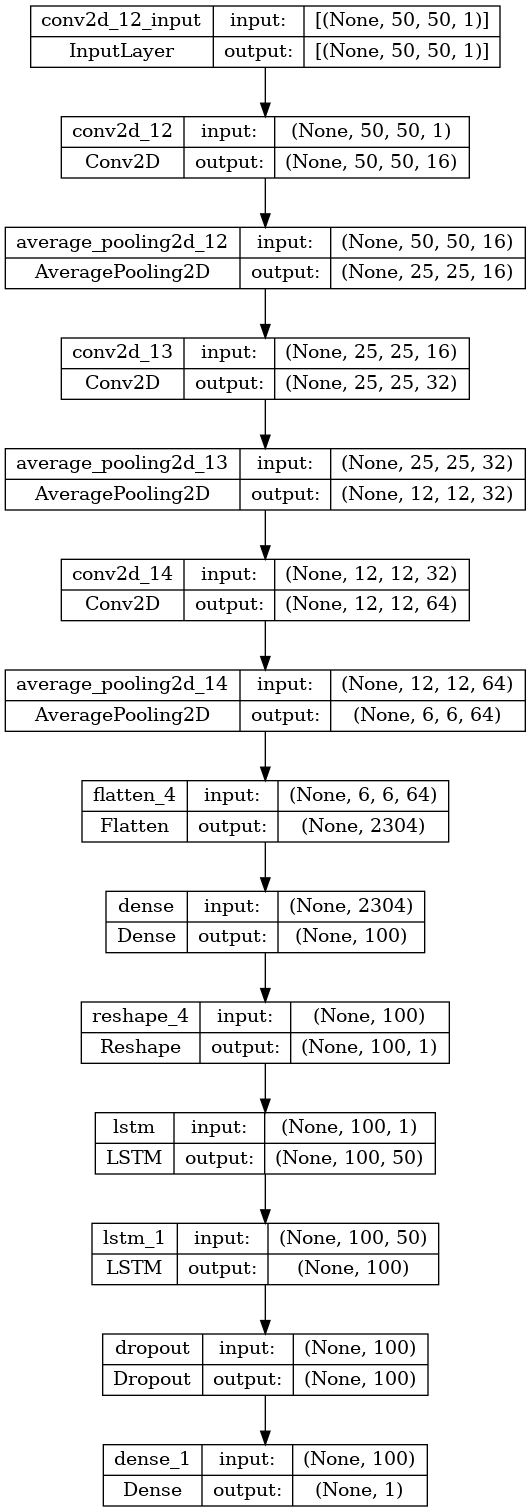

In [21]:
#plot the model 
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)